In [2]:
import numpy as np
from matplotlib import pyplot as plt
import nsmod
import os 
from numpy import cos, sin
%matplotlib inline

from nsmod.one_component_model_with_Euler import main


%load_ext autoreload
%autoreload 2

from nsmod import Plot, File_Functions, Physics_Functions

BETA FUNCTION IS USED
BETA FUNCTION IS USED


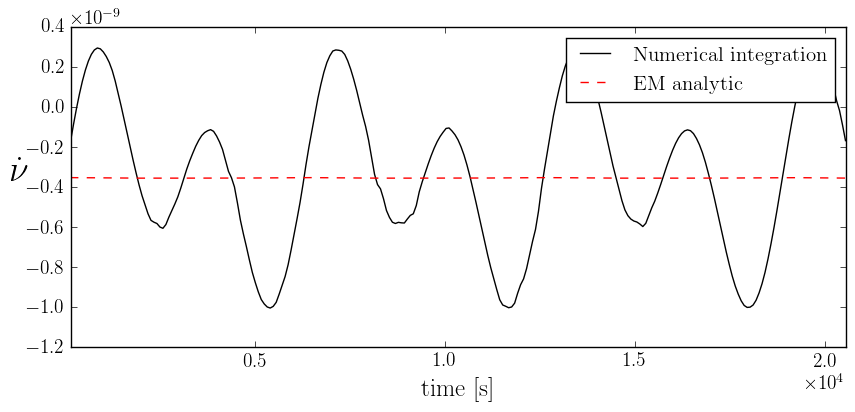

In [114]:
def SignalModel_EM(theta1, t):
    omega0, epsI, a0, chi, epsA = theta1
    
    c = 3e10
    R = 1e6
    k = 2/3.0 * R/c * epsA
    
    #omega = omega0 - k * omega0**3 * t * sin(chi)**2
    psi = -epsI * omega0 * t + np.pi/2 #+ 0.5 * k * epsI * omega0**3  * t**2 * sin(chi)**2+ np.pi/2
    
    omega = (2*k*sin(chi)**2*t + omega0**-2)**(-0.5)
    C =  np.pi/2 + epsI/(k*sin(chi)**2 * omega0)
    #psi = -epsI/(k*sin(chi)**2) * (2*k*sin(chi)**2*t + omega0**-2)**(0.5) + C   

    
    Sin2Theta = 1 - (sin(a0)*sin(psi)*sin(chi) + cos(a0)*cos(chi))**2
    Phidot = omega 
    
    theta = a0
    psidot = epsI * omega0 #+ k * omega0**3 * epsI * t
    
    GEOMETRIC = psidot**2 * ((2*sin(chi)**3*sin(psi)*sin(theta)*cos(theta) - 
                              sin(chi)**2*sin(psi)**2*sin(theta)**2*cos(chi) - 
                              2*sin(chi)**2*sin(theta)**2*cos(chi) + 
                              sin(chi)**2*cos(chi) - sin(theta)**2*cos(chi)**3
                             )*sin(chi)*sin(theta)*cos(psi)/(
                            (sin(chi)*sin(psi)*cos(theta) - sin(theta)*cos(chi))**2 + 
                             sin(chi)**2*cos(psi)**2)**2
                            )/ (2*np.pi)
    
    return  -k * Phidot**3 * Sin2Theta / (2*np.pi) #+ GEOMETRIC

def SignalModel_EM2(params, t):
    omega0, epsI, a0, chi, epsA = params

    theta = a0

    c = 3e10
    R = 1e6
    k = 2/3.0 * R/c * epsA

    psidot = -epsI*omega0 
    psi = -epsI*omega0*t + np.pi/2 #+ 0.5*k*epsI*sin(chi)**2*omega0**3*t**2 
    
    C = 1 - (cos(theta)*cos(chi))**2 - 0.5*(sin(theta)*sin(chi))**2
    tauP = 1./(epsI*omega0)
    tauS = 1./(k*epsA*omega0**2)

    I1 = tauP * cos(t/tauP) + .5*sin(chi)**2/(tauS*tauP) * (
                cos(t/tauP)*t**3/3.0 - tauP * sin(t/tauP)*t**2)
    I2 = -.5*tauP *sin(2*t/tauP) + sin(chi)**2/(tauS*tauP) * (
                sin(2*t/tauP)*t**3/3.0 + .5*tauP * cos(2*t/tauP)*t**2)

    Phidot3 = (2*k*(C*t + (.5*sin(2*theta)*sin(2*chi)*I1
                                      - .25*(sin(theta)*sin(chi))**2*I2))
               + omega0**-2
               )**(-3./2)
    Sin2Theta = 1 - (sin(theta)*sin(psi)*sin(chi) + cos(theta)*cos(chi))**2

    theta = a0

    GEOMETRIC = psidot**2 * ((2*sin(chi)**3*sin(psi)*sin(theta)*cos(theta) -
                              sin(chi)**2*sin(psi)**2*sin(theta)**2*cos(chi) -
                              2*sin(chi)**2*sin(theta)**2*cos(chi) +
                              sin(chi)**2*cos(chi) - sin(theta)**2*cos(chi)**3
                             )*sin(chi)*sin(theta)*cos(psi)/(
                            (sin(chi)*sin(psi)*cos(theta) - sin(theta)*cos(chi))**2 +
                             sin(chi)**2*cos(psi)**2)**2
                            )/ (2*np.pi)

    return  -k * Phidot3 * Sin2Theta / (2*np.pi) + GEOMETRIC

def SignalModel(params, t):
    omega0, epsI, a0, chi, epsA = params

    theta = a0

    c = 3e10
    R = 1e6
    k = 2/3.0 * R/c * epsA
    tauP = 1./(epsI*omega0)

    psidot = -epsI*omega0 
    psi = -epsI*omega0*t + np.pi/2 + 0.5*k*epsI*sin(chi)**2*omega0**3*t**2 
    
    C = 1 - (cos(theta)*cos(chi))**2 - 0.5*(sin(theta)*sin(chi))**2
    
    T1 = -k * omega0**3 * C 
    T2 =  3*k**2*omega0**5 * C**2 * t
    
    T3 = 0.5 * k * omega0**3 *(sin(2*theta)*sin(2*chi)*sin(psi) - 
                               (sin(theta)*sin(chi))**2*cos(2*psi))
    
    T4 = 1.5*k**2*omega0**5*C*(-sin(2*theta)*sin(2*chi)*(tauP*cos(psi) + t*sin(psi))
                               +(sin(theta)*sin(chi))**2*(.5*tauP*sin(2*psi) + t*cos(2*psi)))
    
    T5 = 0.75*k**2*omega0**5*tauP*(
              (sin(2*theta)*sin(2*chi)*cos(psi) 
               - 0.5*((sin(theta)*sin(chi))**2*sin(2*psi))) * 
              (sin(2*theta)*sin(2*chi)*sin(psi) 
               - ((sin(theta)*sin(chi))**2*cos(2*psi))))
    
    return  (T1 + T2 + T3 + T4 + T5)/(2*np.pi)


fig, ax1 = plt.subplots(figsize=(10, 4))

# Parameter3
epsI3 = 1e-5
epsA = 1e-10
omega0 = 100
a0 = 3
chi0 = 88.0

tauP = 2 * np.pi/abs(epsI3 * omega0)
T = 3.3* tauP

n = 100000
error = 1e-16

# Exact numerical result
file_name = main(chi0=chi0, epsI3=epsI3, epsA=epsA, omega0=omega0, T=T, 
                 n=n, error=error, a0=a0, 
                 cleanup=False, 
                 #DryRun=True, 
                 AnomTorque=False)

#File_Functions.PrintParameterDictionary(file_name)

ax1 = Plot.SpindownRate(file_name, ax=ax1, analytic="", 
                        divisor=20, method="Lyne",
                        label="Numerical integration")

time = np.linspace(0, T, 1000)

PD = File_Functions.Parameter_Dictionary(file_name)
nu_dot0 = PD['nu_dot0']

# EM model
#theta_EM = np.array([omega0, epsI3, np.radians(a0), np.radians(chi0), epsA])
#ax1.plot(time, SignalModel_EM(theta_EM, time), color="b", label="EM analytic")

theta_EM = np.array([omega0, epsI3, np.radians(a0), np.radians(chi0), epsA])
ax1.plot(time, SignalModel(theta_EM, time), color="r", ls="--", label="EM analytic")

plt.legend()
plt.show()

BETA FUNCTION IS USED


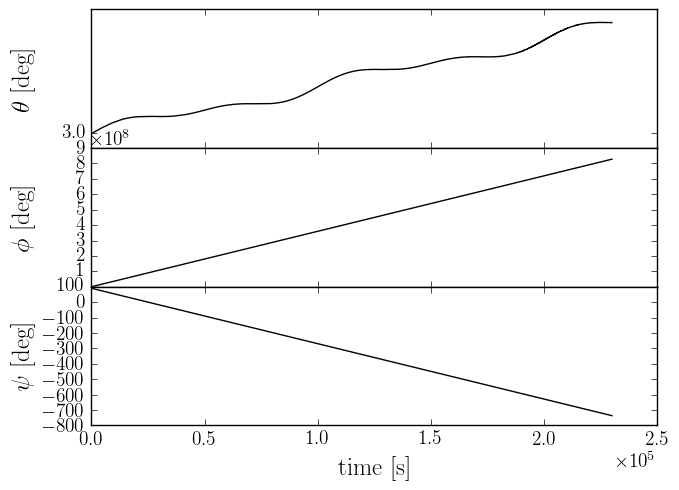

In [19]:
Plot.Euler_Angles(file_name)
plt.show()

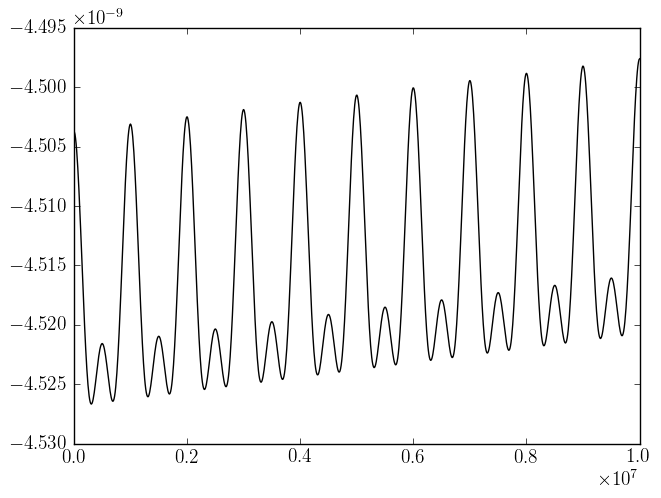

In [42]:
def SignalModel_EM2(params, t):
    omega0, epsI, a0, chi, epsA = params
    
    theta = a0
    
    c = 3e10
    R = 1e6
    k = 2/3.0 * R/c * epsA
    
    psidot = -epsI*omega0
    psi = psidot*t + np.pi/2 
    C = 1 - (cos(theta)*cos(chi))**2 - 0.5*(sin(theta)*sin(chi))**2
    tauP = 1./(epsI3*omega0)
    tauS = 1./(k*epsA*omega0**2)
    
    I1 = tauP * cos(t/tauP) + .5*sin(chi)**2/(tauS*tauP) * (
                cos(t/tauP)*t**3/3.0 - tauP * sin(t/tauP)*t**2)
    I2 = -.5*tauP *sin(2*t/tauP) + sin(chi)**2/(tauS*tauP) * (
                sin(2*t/tauP)*t**3/3.0 + .5*tauP * cos(2*t/tauP)*t**2)    
    
    Phidot3 = (2*k*(C*t + (.5*sin(2*theta)*sin(2*chi)*I1
                                      - .25*(sin(theta)*sin(chi))**2*I2))
               + omega0**-2
               )**(-3./2)
    Sin2Theta = 1 - (sin(theta)*sin(psi)*sin(chi) + cos(theta)*cos(chi))**2
    
    return  -k * Phidot3 * Sin2Theta / (2*np.pi) 

epsI3 = 1e-8
epsA = 5.16e-12
omega0 = 2*np.pi*100
a0 = 3
chi0 = 88.9

time = np.linspace(0, 1e7, 1000)
theta_EM = np.array([omega0, epsI3, np.radians(a0), np.radians(chi0), epsA])
plt.plot(time, SignalModel_EM2(theta_EM, time))
plt.show()